In [40]:
# GLOBAL VARIABLES
GIT_URL = "https://github.com/chaimaeouardani/img_classification"
IMG_BASE = "img_classification/"
CLASSES = ["hiver", "printemps", "ete", "automne"]


In [41]:
!git clone $GIT_URL
!git -C img_classification pull 

fatal: destination path 'img_classification' already exists and is not an empty directory.
Already up to date.


# Chargement des données :

In [42]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

def load_data(data_path, classes, dataset, image_size=64):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    print(f"Found {num_images}.")

    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        print(f"Processing class \"{classes[idx_class]}\":")
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            print(f"\r\033[K- Processing image {idx_img+1}/{len(dirs)}", end = "")
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1

        print(f"\r\033[KFinished processing {classes[idx_class]}")

    return x, y

In [43]:
labels = CLASSES

print("--------loading train data-------")
x_train, y_train = load_data(IMG_BASE, labels, dataset='train', image_size=64)
print(x_train.shape, y_train.shape)
print("--------loading validation data-------")
x_val, y_val = load_data(IMG_BASE, labels, dataset='validation', image_size=64)
print(x_val.shape, y_val.shape)
print("--------loading test data-------")
x_test, y_test = load_data(IMG_BASE, labels, dataset='test', image_size=64)
print(x_test.shape, y_test.shape)

--------loading train data-------
Found 4703.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(4703, 64, 64, 3) (4703, 1)
--------loading validation data-------
Found 1996.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(1996, 64, 64, 3) (1996, 1)
--------loading test data-------
Found 1836.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(1836, 64, 64, 3) (1836, 1)


Normalisation des entrées via une division par 255 des valeurs de pixel.


In [44]:
#x_train /= 255
#x_val /= 255
#x_test /= 255

# Visualisation des images

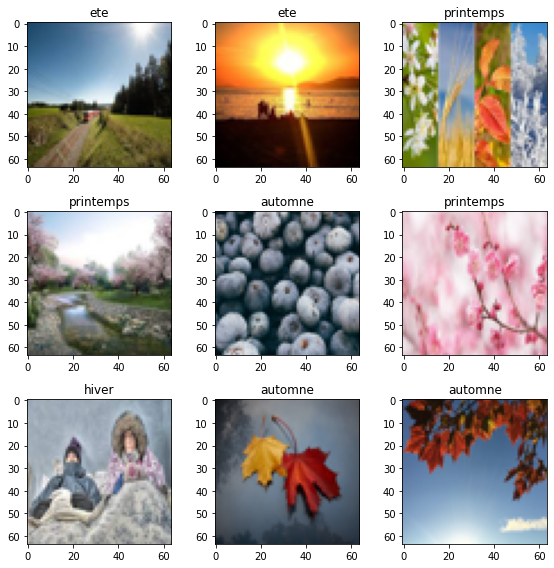

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
shuffle_indices = np.random.permutation(y_train.shape[0])
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

## Réseau convolutif de base et entrainement des données 

In [46]:
import numpy as np
import math
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn import datasets

from tensorflow.keras.layers import Conv2D, MaxPooling2D , Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers , Input

In [66]:
def create_model():
  model = Sequential()
  #model.add(Input(shape=(64, 64, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, kernel_size= (3,3), padding='same', activation = 'relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Conv2D(96, kernel_size= (3,3), padding='same', activation = 'relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Conv2D(128, kernel_size= (3,3), padding='same',  activation = 'relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Flatten())

  model.add(Dense(512, activation='relu'))
  model.add(Dense(4, activation='sigmoid'))

  model.build()

  #model.add(tensorflow.keras.layers.Reshape((2,4)))
  model.summary()

  return model 

In [67]:
model = create_model()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 16, 16, 96)        55392     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 8, 8, 96)        

In [69]:
# compile model
opt = optimizers.Adam(learning_rate=3e-4)
#opt = optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy' , metrics = ['accuracy'])

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

Epoch 1/10
147/147 [==============================] - 2s 12ms/step - loss: 2.9241 - accuracy: 0.5537 - val_loss: 0.7549 - val_accuracy: 0.7144
Epoch 2/10
147/147 [==============================] - 1s 8ms/step - loss: 0.7394 - accuracy: 0.7212 - val_loss: 0.6431 - val_accuracy: 0.7560
Epoch 3/10
147/147 [==============================] - 1s 9ms/step - loss: 0.6215 - accuracy: 0.7721 - val_loss: 0.6147 - val_accuracy: 0.7645
Epoch 4/10
147/147 [==============================] - 1s 9ms/step - loss: 0.5250 - accuracy: 0.8076 - val_loss: 0.4259 - val_accuracy: 0.8407
Epoch 5/10
147/147 [==============================] - 1s 8ms/step - loss: 0.4274 - accuracy: 0.8478 - val_loss: 0.3795 - val_accuracy: 0.8577
Epoch 6/10
147/147 [==============================] - 1s 9ms/step - loss: 0.3266 - accuracy: 0.8860 - val_loss: 0.2049 - val_accuracy: 0.9389
Epoch 7/10
147/147 [==============================] - 1s 8ms/step - loss: 0.2900 - accuracy: 0.8967 - val_loss: 0.1679 - val_accuracy: 0.9454
Epoch

# Affichage de l'ananlyse de l'entrainement

In [70]:
def plot_training_analysis(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

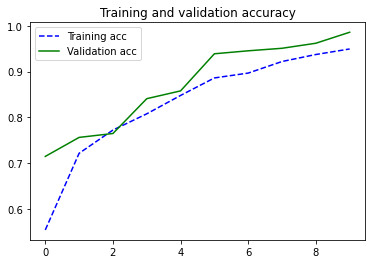

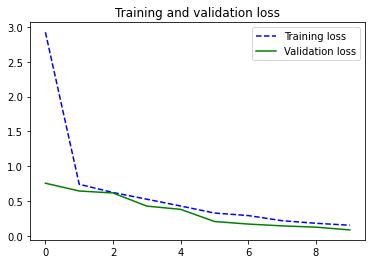

In [71]:

plot_training_analysis(history)


Evaluation pour les données de test :

In [72]:
model.evaluate(x_test,y_test)

58/58 [==============================] - 0s 5ms/step - loss: 0.0899 - accuracy: 0.9804


[0.08988939225673676, 0.9803921580314636]

## Augmentation de la base de données : 

On utilise deux types d'augmentation : des transformations spatiales (ShiftScaleRotate), et des transformations colorimétriques. 

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.2,1.0]
    )


Visualisation des images passées à travers notre boucle d'augmentation de données.

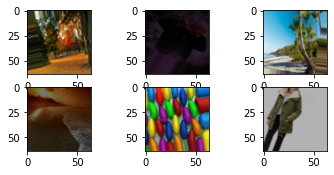

In [74]:

# prepare iterator
it = datagen.flow(x_train, batch_size=5)
# generate samples and plot
for i in range(6):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

Nous allons recréer un autre modèle et relancer l'entraînement.

In [75]:
model2 = create_model()
opt = optimizers.Adam(learning_rate=3e-4)

model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy' , metrics = ['accuracy'])


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 96)        55392     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 8, 8, 96)       

In [77]:
hist2 = model2.fit(datagen.flow(x_train, y_train, batch_size=40), validation_data=(x_val, y_val), epochs=50)


Epoch 1/50
118/118 [==============================] - 8s 64ms/step - loss: 0.5955 - accuracy: 0.2549 - val_loss: 0.4750 - val_accuracy: 0.2355
Epoch 2/50
118/118 [==============================] - 7s 63ms/step - loss: 0.5710 - accuracy: 0.2488 - val_loss: 0.5151 - val_accuracy: 0.2470
Epoch 3/50
118/118 [==============================] - 8s 64ms/step - loss: 0.5407 - accuracy: 0.2541 - val_loss: 0.5063 - val_accuracy: 0.2275
Epoch 4/50
118/118 [==============================] - 8s 64ms/step - loss: 0.5385 - accuracy: 0.2501 - val_loss: 0.4517 - val_accuracy: 0.2430
Epoch 5/50
118/118 [==============================] - 7s 63ms/step - loss: 0.5281 - accuracy: 0.2492 - val_loss: 0.4789 - val_accuracy: 0.2169
Epoch 6/50
118/118 [==============================] - 7s 63ms/step - loss: 0.5336 - accuracy: 0.2443 - val_loss: 0.4780 - val_accuracy: 0.2380
Epoch 7/50
118/118 [==============================] - 7s 62ms/step - loss: 0.5396 - accuracy: 0.2450 - val_loss: 0.4190 - val_accuracy: 0.2786

KeyboardInterrupt: ignored

## Tester pour des entrées non présentes dans les données d'entrainement:

In [57]:
#enregistrer le modèle 2
model.save('weather_model2.h5')

In [58]:
def load_image(path):
  img = Image.open(path)
  img = img.convert('RGB')
  img = img.resize((64,64))
  return np.asarray(img)

In [59]:
from keras.models import load_model

img = load_image('img_classification/test.jpg')
m = load_model('weather_model2.h5')
result = m.predict(img)


ValueError: ignored

In [ ]:
result[0]